In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers.convolutional import UpSampling2D
from IPython.display import clear_output
from keras.datasets import fashion_mnist
from keras.models import Sequential, load_model, Model
from keras.layers import Dense , Activation , Dropout ,Flatten, BatchNormalization, Embedding, ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import LSTM, Dense
from keras.models import load_model
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import accuracy_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


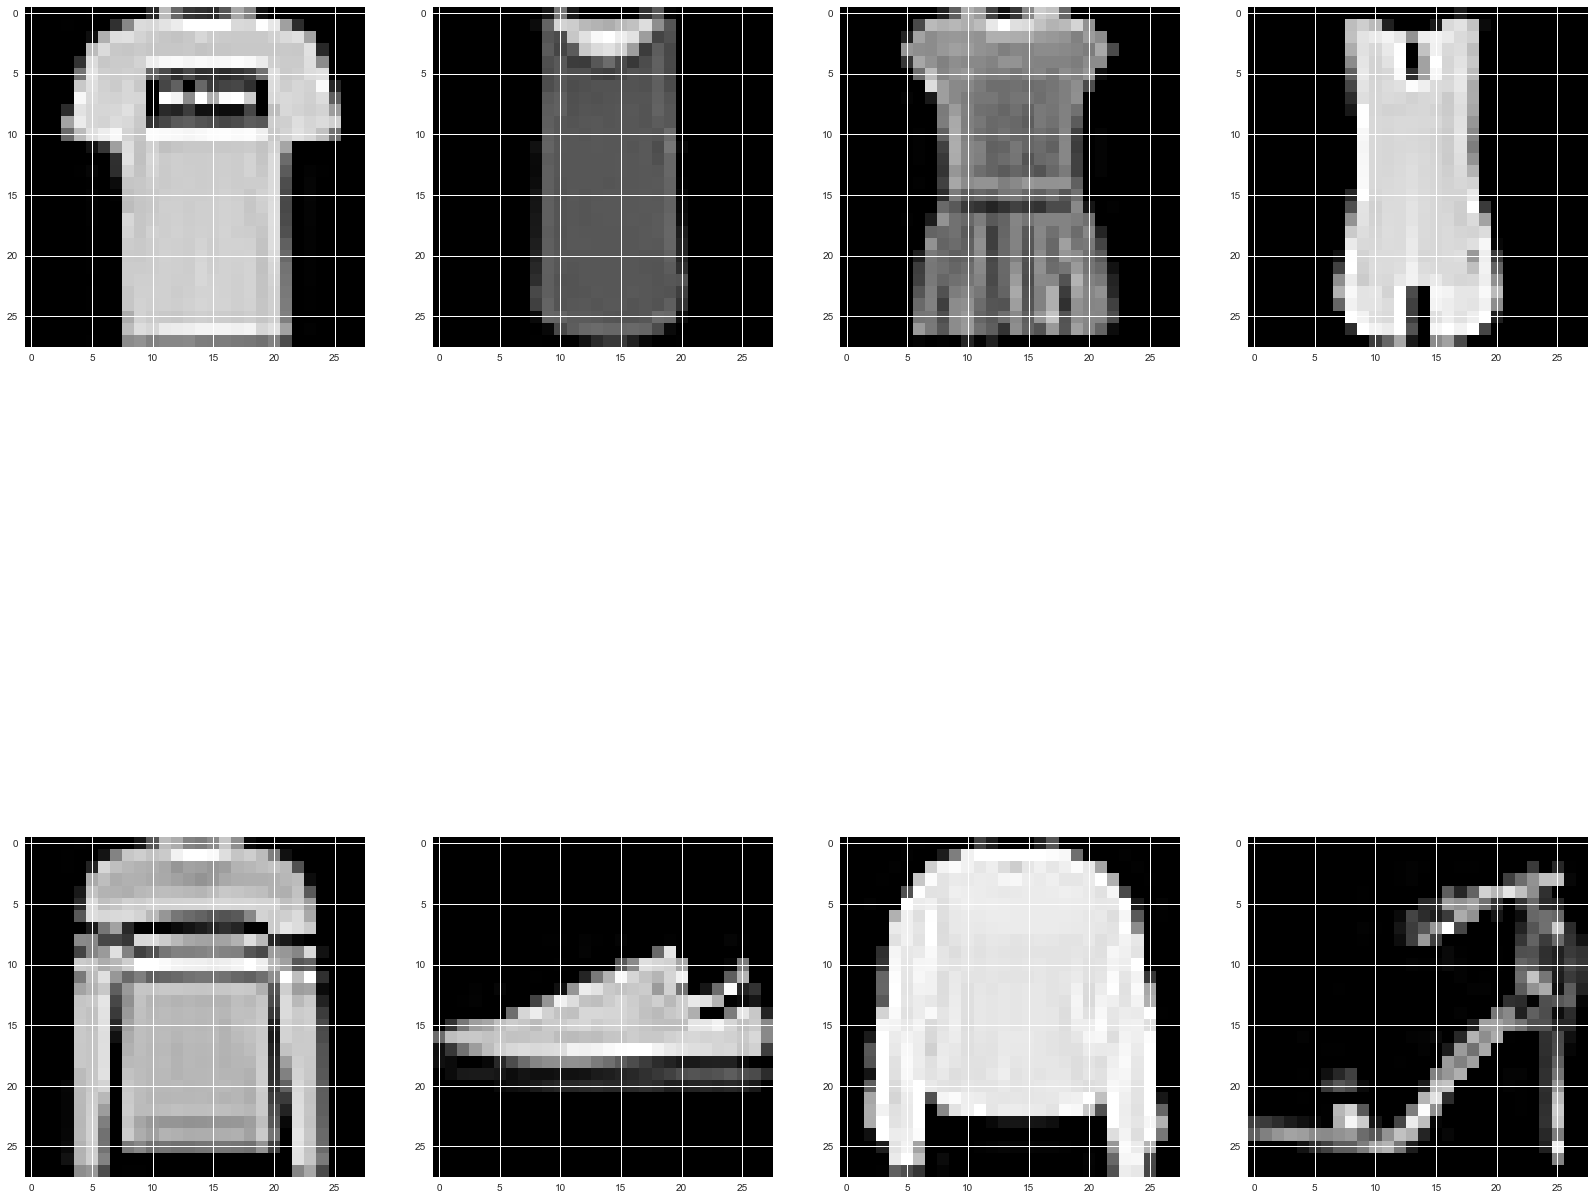

In [29]:
(X_train,Y_train),(X_test,Y_test) = fashion_mnist.load_data()
X_train = X_train/255
X_test = X_test/255

fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()

In [30]:
X_train.shape

(60000, 28, 28)

In [31]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1).astype('float32')
num_class = 10
Y_train = to_categorical(Y_train, num_classes=num_class)

In [5]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [6]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()
    return model

In [7]:
class LSTMClassifier(object):
    def __init__(self):
        self.time_steps=28 
        self.n_units=128 
        self.n_inputs=28 
        self.n_classes=10
        self.batch_size=128
        self.n_epochs=20
        self._trained = False

    def __create_model(self):
        self.model = Sequential()
        self.model.add(LSTM(self.n_units, input_shape=(self.time_steps, self.n_inputs)))
        self.model.add(Dense(self.n_classes, activation='softmax'))

        self.model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])
        self.model.summary()

    def train(self, x_train, y_train):
        self.__create_model()
        x_train = x_train.reshape((-1, self.time_steps, self.n_inputs))
        self.model.fit(x_train, y_train,
                  batch_size=self.batch_size, epochs=self.n_epochs, validation_data=(X_test,Y_test), 
                       shuffle=False, callbacks=[plot_losses])
        self._trained = True

In [8]:
def mlp_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    model.summary()
    return model

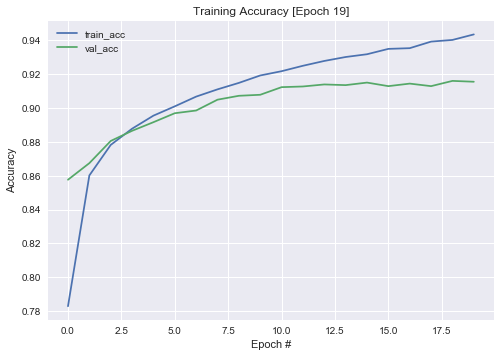

In [9]:
cnn_model = baseline_model()
X_test = X_test.reshape((X_test.shape[0],28,28,1))
cnn_model.fit(X_train, Y_train, epochs=20,validation_data=(X_test,Y_test), batch_size=128,callbacks=[plot_losses] )

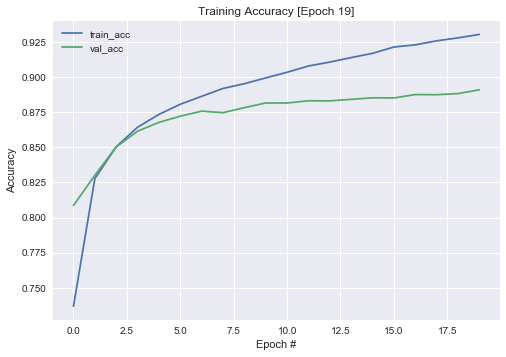

In [10]:
lstm_model = LSTMClassifier()
X_test = X_test.reshape((X_test.shape[0],28,28))
lstm_model.train(X_train,Y_train)

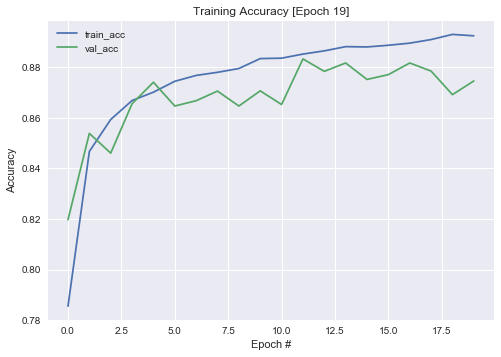

In [11]:
mlp_model = mlp_model()
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0],784)
mlp_model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=20, batch_size=128, callbacks=[plot_losses])

In [32]:
X_test = X_test.reshape((X_test.shape[0],28,28,1))
pred1 = cnn_model.predict(X_test)
cnn_pred = [np.argmax(p) for p in pred1]  
cnn_pred = np.array(cnn_pred)
accuracy = accuracy_score(Y_test,cnn_pred)
accuracy

0.9155

In [33]:
X_test = X_test.reshape((X_test.shape[0],28,28))
pred2 = lstm_model.model.predict(X_test)
lstm_pred = [np.argmax(p) for p in pred2]  
lstm_pred = np.array(lstm_pred)
accuracy = accuracy_score(Y_test,lstm_pred)
accuracy

0.891

In [34]:
X_test = X_test.reshape(X_test.shape[0],784)
pred3 = mlp_model.predict(X_test)
mlp_pred = [np.argmax(p) for p in pred3]
mlp_pred = np.array(mlp_pred)
accuracy = accuracy_score(Y_test,mlp_pred)
accuracy

0.8745

In [35]:
pred = (2*pred1+1*pred2+1*pred3)/4
ens_pred = [np.argmax(p) for p in pred]
ens_pred = np.array(ens_pred)
ensemble_soft_accuracy = accuracy_score(Y_test,ens_pred)
ensemble_soft_accuracy

0.9199

In [36]:
import statistics
from statistics import mode
Y_pred = [mode([lstm_pred[i],lstm_pred[i],lstm_pred[i],
                         cnn_pred[i],cnn_pred[i],cnn_pred[i],cnn_pred[i],
                         mlp_pred[i],mlp_pred[i],mlp_pred[i]]) for i in range(len(cnn_pred)) ]

In [37]:
ensemble_hard_accuracy = accuracy_score(Y_test,Y_pred)
ensemble_hard_accuracy

0.9113

In [38]:
X_test = X_test.reshape((X_test.shape[0],28,28,1))
pred1 = cnn_model.predict(X_test)
cnn_pred = [np.argmax(p) for p in pred1]  
cnn_pred = np.array(cnn_pred)

X_test = X_test.reshape((X_test.shape[0],28,28))
pred2 = lstm_model.model.predict(X_test)
lstm_pred = [np.argmax(p) for p in pred2]  
lstm_pred = np.array(lstm_pred)

X_test = X_test.reshape(X_test.shape[0],784)
pred3 = mlp_model.predict(X_test)
mlp_pred = [np.argmax(p) for p in pred3]
mlp_pred = np.array(mlp_pred)

import statistics
def find_max_mode(list1):
    list_table = statistics._counts(list1)
    len_table = len(list_table)

    if len_table == 1:
        max_mode = statistics.mode(list1)
    else:
        new_list = []
        for i in range(len_table):
            new_list.append(list_table[i][0])
        max_mode = max(new_list) # use the max value here
    return max_mode

Y_pred = [find_max_mode([lstm_pred[i],cnn_pred[i],mlp_pred[i]]) 
          for i in range(len(cnn_pred)) ]
ensemble_hard_accuracy = accuracy_score(Y_test,Y_pred)
ensemble_hard_accuracy

0.9103

In [39]:
X_test = X_test.reshape((X_test.shape[0],28,28,1))
pred1 = cnn_model.predict(X_test)

X_test = X_test.reshape((X_test.shape[0],28,28))
pred2 = lstm_model.model.predict(X_test)

X_test = X_test.reshape(X_test.shape[0],784)
pred3 = mlp_model.predict(X_test)

pred = (1*pred1+1*pred2+1*pred3)/4
ens_pred = [np.argmax(p) for p in pred]
ens_pred = np.array(ens_pred)
ensemble_soft_accuracy = accuracy_score(Y_test,ens_pred)
ensemble_soft_accuracy

0.9147

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[884   0  22  13   4   1  73   0   3   0]
 [  2 973   1  18   3   0   2   0   1   0]
 [ 14   0 901   6  50   0  29   0   0   0]
 [ 14   1  12 929  28   0  14   0   2   0]
 [  1   0  82  21 843   0  53   0   0   0]
 [  0   0   0   0   0 977   0  13   1   9]
 [115   1  85  24  46   0 721   0   8   0]
 [  0   0   0   0   0   8   0 978   0  14]
 [  1   0   6   5   2   3   0   4 979   0]
 [  0   0   0   0   0   4   1  33   0 962]]
Normalized confusion matrix
[[0.88 0.   0.02 0.01 0.   0.   0.07 0.   0.   0.  ]
 [0.   0.97 0.   0.02 0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.9  0.01 0.05 0.   0.03 0.   0.   0.  ]
 [0.01 0.   0.01 0.93 0.03 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.08 0.02 0.84 0.   0.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.98 0.   0.01 0.   0.01]
 [0.12 0.   0.09 0.02 0.05 0.   0.72 0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.98 0.   0.01]
 [0.   0.   0.01 0.01 0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.   0.

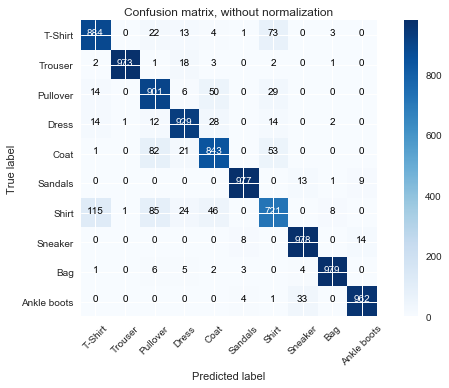

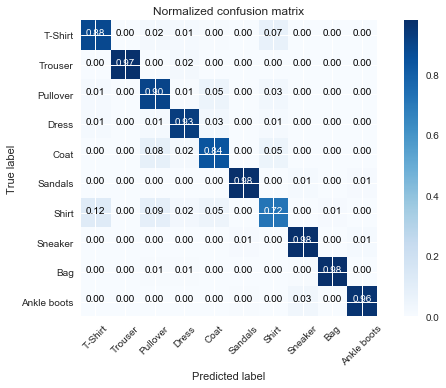

In [41]:
label_map = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandals', 'Shirt', 'Sneaker', 'Bag', 'Ankle boots']
cnf_matrix = confusion_matrix(Y_test, ens_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_map,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_map, normalize=True,
                      title='Normalized confusion matrix')

plt.show()